## CNN Regression on Galsim simulation data
Ziwei Qiu: ziweiqiu@g.harvard.edu

### Import libraries

In [1]:
import sys
import math
import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

###  Import data, make train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [2]:
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

total number of images: 18779


In [3]:
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = np.sort(train_ind)
test_ind = ind[split:]
test_ind = np.sort(test_ind)

# train dataset
image_tr = f['img'][train_ind]
cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

training set done.
test set done.


In [4]:
# Reshape such that the images are ready for training
image_tr = image_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_te.reshape(image_te.shape[0],64,64,1)

image_nonoise_tr = image_nonoise_tr.reshape(image_nonoise_tr.shape[0],64,64,1)
image_nonoise_te = image_nonoise_te.reshape(image_nonoise_te.shape[0],64,64,1)

image_withnoise_tr = image_withnoise_tr.reshape(image_withnoise_tr.shape[0],64,64,1)
image_withnoise_te = image_withnoise_te.reshape(image_withnoise_te.shape[0],64,64,1)

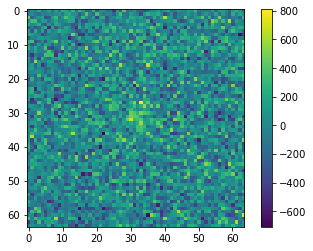

In [5]:
# An example from the training set
plt.imshow(image_withnoise_tr[1,:,:,0])
plt.colorbar()
plt.show()

In [6]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

###  Define the common functions for regression on different parameters

#### Define a function so the training process will automatically save the weights with the lowest possible val_loss
Note that we should use image_withnoise, not image...

In [7]:
# Two different model architectures
def build_model_shallow(verbose = 1):
    cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()

def build_model_deep(verbose = 1):
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.2))

    cnnmodel1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()
        
def build_model_deep2(verbose=1):
    cnnmodel1.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()

#### Save the lowest val_loss model and top when the time is over

In [8]:
def smart_training(cnnmodel, label_ind, weight_filename, 
                   max_time_min = 45, lr_ini = 0.001, lr_decay = 0.5, 
                   val_loss_goal = 0.05, verbose=0):
    
    ''' max_time_min: the longest training time in minutes '''
    
    tic = time.time()
    lr = lr_ini
    opt = SGD(lr=lr, momentum=0.9)
    cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
    cnnmodel_fit = cnnmodel.fit(image_withnoise_tr, label_tr_scaled[:,label_ind], epochs=1,
                                batch_size=64, shuffle=True, verbose=verbose, 
                                validation_data=(image_withnoise_te, label_te_scaled[:,label_ind]))
    cnnmodel.save_weights(weight_filename)
    current_val_loss = cnnmodel_fit.history['val_loss'][-1]
    print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
    
    while True:
        if time.time() - tic > max_time_min*60:
            print('{} min has passed. Time is over!'.format(max_time_min))
            break
        
        cnnmodel_fit = cnnmodel.fit(image_withnoise_tr, label_tr_scaled[:,label_ind], epochs=1,
                                    batch_size=64, shuffle=True, verbose=verbose, 
                                    validation_data=(image_withnoise_te, label_te_scaled[:,label_ind]))
        if cnnmodel_fit.history['val_loss'][-1] < current_val_loss:
            cnnmodel.save_weights(weight_filename)
            current_val_loss = cnnmodel_fit.history['val_loss'][-1]
            print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
            lr = lr*lr_decay
            opt = SGD(lr=lr, momentum=0.9)
            cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
        if current_val_loss < val_loss_goal:
            print('Reached the goal! (total training time: {} min)'.format(int((time.time() - tic)/60)))
            break

#### Load pre-trained weights and evaluate the validation loss

In [9]:
def load_weights(cnnmodel, label_ind, weight_filename):
    #opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt = SGD(lr=0.001, momentum=0.9)
    cnnmodel.compile(optimizer=opt, loss='mae', metrics=['mse','mae'])
    cnnmodel.load_weights(weight_filename)
    print("Loaded " + weight_filename + " from disk")
    
    #  Evaluate the model on the validation data:
    val_loss = cnnmodel.evaluate(image_withnoise_te, label_te_scaled[:,label_ind],verbose = 0)
    print('The validation loss MAE is {:0.6f}.'.format(val_loss[0]))

#### Visualize the prediction versus true values using test data

In [10]:
# Evaluation
def plot_prediction(cnnmodel, label_ind, num_of_pts = 200, X_test = image_withnoise_te):

    indices = np.random.randint(0,X_test.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    single_scaler.fit(np.expand_dims(label_tr[:,label_ind],axis=1))

    label_pred_scaled = cnnmodel.predict(X_test[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(5,4))
    plt.scatter(label_te[indices,label_ind],label_pred, 
                c = snr_te[indices], cmap="seismic", s = 20)
    plt.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    plt.xlabel('True Value', fontsize = 13)
    plt.ylabel('Predicted Value', fontsize = 13)
    plt.title(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

#### Estimate prediction uncertainty. Add noise to a clean galaxy image given a certain SNR, predict the parameter. Repeat for many times, and the standard deviation gives the prediction uncertainty.

In [11]:
def make_noisy_galaxy(galaxy_no_noise, snr, size):
    '''input: galaxy_no_noise is of shape (64,64,1)
       output is a bunch of noisy galaxies with pre-defined SNR, of shape (size, 64,64,1)    
    '''
    galaxy_reshaped = galaxy_no_noise[:,:,0]
    galaxy_with_noise = np.zeros((size,64,64))
    for i in range(size): 
        noise = np.sqrt((galaxy_reshaped**2).sum()) / snr
        noisemap = np.random.normal(0, noise, 64*64)
        noisemap=noisemap.reshape((64,64))
        galaxy_with_noise[i]= galaxy_reshaped+noisemap # final noised image 
    galaxy_with_noise = galaxy_with_noise.reshape(galaxy_with_noise.shape[0],64,64,1)
    # galaxy_with_noise is of shape (size, 64,64,1), ready to be fed into the model 
    return galaxy_with_noise

def get_uncertainty(cnnmodel, label_ind, galaxy_no_noise, snr, size):
    '''Give the uncertainty of prediction given SNR'''
    galaxy_with_noise = make_noisy_galaxy(galaxy_no_noise, snr, size)
    single_scaler = StandardScaler()
    single_scaler.fit(np.expand_dims(label_tr[:,label_ind],axis=1))
    label_pred_scaled = cnnmodel.predict(galaxy_with_noise)
    label_pred = single_scaler.inverse_transform(label_pred_scaled)
    
    mean = label_pred.mean()
    sigma = label_pred.std()
    
    return mean, sigma, label_pred

def plot_uncertainty(cnnmodel, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100):
    np.random.seed(200)
    indices = np.random.randint(0,image_withnoise_te.shape[0],num_of_pts)
    true_values = label_te[indices,label_ind]
    mean = np.zeros(num_of_pts)
    sigma = np.zeros(num_of_pts)
    label_pred = np.zeros([num_of_pts, sampling_size])
    x = np.linspace(label_te[:,label_ind].min(),label_te[:,label_ind].max(),20)
    fig,ax = plt.subplots(2,2,figsize=(7,6.5), sharex = True)
    
    CRB_snr30 = [[1,0.11], [3, 1.56],[0.3, 0.056], [-0.069, 0.11], [0.15, 0.11]]
    CRB_snr60 = [[1,0.056], [3, 0.78],[0.3, 0.028], [-0.069, 0.054], [0.15, 0.054]]
    
    for j in range(2):
        i = 0
        for idx in indices:
            mean[i], sigma[i], label_pred_temp = get_uncertainty(cnnmodel, label_ind, image_nonoise_te[idx], snr[j], size=sampling_size)
            label_pred[i] = label_pred_temp[:,0]
            i+=1
        
        ax[0][j].set_title(label_names_list[label_ind]+'\nSNR = {}'.format(snr[j]))
        ax[0][j].errorbar(true_values, mean, yerr=sigma, fmt='.', label = 'CNN model')
        ax[0][j].legend()
        ax[0][j].plot(x,x,color = 'tab:orange')
        ax[1][j].scatter(true_values, sigma, s = 20, label = 'CNN model uncertainty')
        if snr[j] == 30:
            ax[1][j].scatter(CRB_snr30[label_ind][0], CRB_snr30[label_ind][1], s = 20, label = 'Cramer-Rau Bound')
        elif snr[j] == 60:
            ax[1][j].scatter(CRB_snr60[label_ind][0], CRB_snr60[label_ind][1], s = 20, label = 'Cramer-Rau Bound')
        ax[1][j].set_xlabel('True Value', fontsize = 13)
        ax[1][j].legend()
    
    ax[0][0].set_ylabel('Predicted Value', fontsize = 13)
    ax[1][0].set_ylabel('Uncertainty',fontsize = 13)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 11})
    plt.show()

### Regression on the label0 flux

##### Architecture 1: Deep CNN layers:

In [12]:
label_ind = 0
cnnmodel1 = models.Sequential()
build_model_deep()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        272       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        4112      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        1

In [12]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_flux_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.651924. Weights saved.
==> Current val_loss lowest record is: 0.158461. Weights saved.
==> Current val_loss lowest record is: 0.129894. Weights saved.
==> Current val_loss lowest record is: 0.125682. Weights saved.
==> Current val_loss lowest record is: 0.125087. Weights saved.
120 min has passed. Time is over!


In [13]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_flux_imprvd.h5')

Loaded cnnmodel_flux_imprvd.h5 from disk
The validation loss MAE is 0.125087.


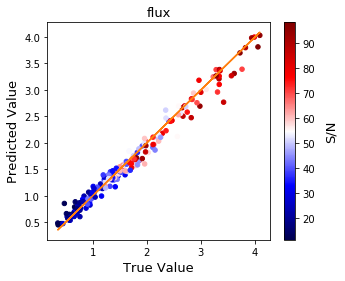

In [14]:
plot_prediction(cnnmodel1, label_ind)

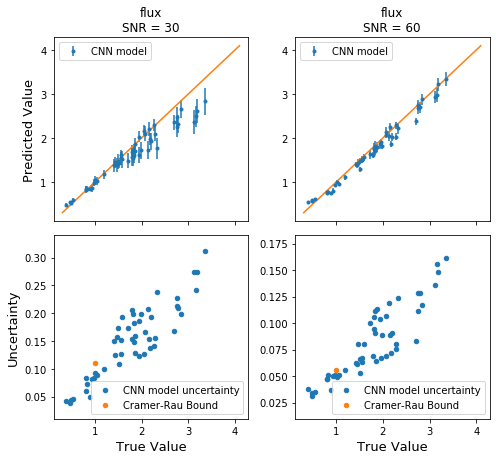

In [15]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [16]:
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [15]:
label_ind = 0
weights_filename = 'cnnmodel_flux_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 1.056936. Weights saved.
==> Current val_loss lowest record is: 0.263323. Weights saved.
==> Current val_loss lowest record is: 0.144727. Weights saved.
==> Current val_loss lowest record is: 0.134845. Weights saved.
==> Current val_loss lowest record is: 0.129009. Weights saved.
120 min has passed. Time is over!


In [17]:
weights_filename = 'cnnmodel_flux_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_flux_v0.h5 from disk
The validation loss MAE is 0.129009.


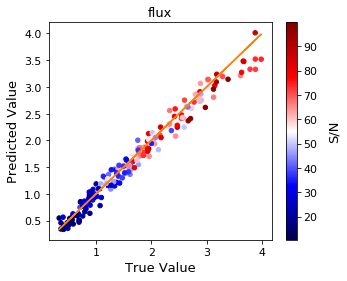

In [18]:
plot_prediction(cnnmodel1, label_ind)

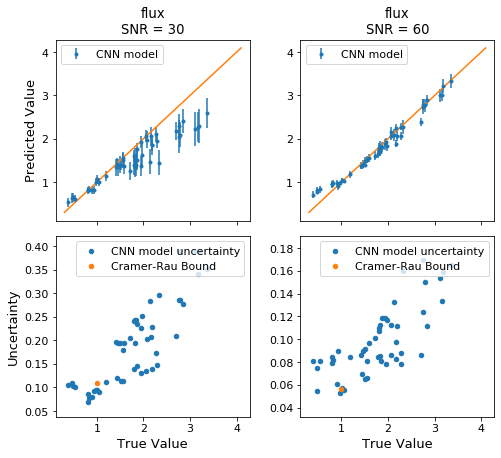

In [19]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

### Regression on the label1 sersic index

##### Architecture 1: Deep CNN layers:

In [20]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [18]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.869347. Weights saved.
==> Current val_loss lowest record is: 0.851990. Weights saved.
==> Current val_loss lowest record is: 0.835536. Weights saved.
==> Current val_loss lowest record is: 0.822561. Weights saved.
==> Current val_loss lowest record is: 0.814042. Weights saved.
==> Current val_loss lowest record is: 0.810861. Weights saved.
==> Current val_loss lowest record is: 0.805875. Weights saved.
==> Current val_loss lowest record is: 0.804253. Weights saved.
==> Current val_loss lowest record is: 0.804099. Weights saved.
==> Current val_loss lowest record is: 0.803768. Weights saved.
==> Current val_loss lowest record is: 0.803374. Weights saved.
==> Current val_loss lowest record is: 0.803295. Weights saved.
==> Current val_loss lowest record is: 0.803172. Weights saved.
==> Current val_loss lowest record is: 0.803119. Weights saved.
==> Current val_loss lowest record is: 0.803078. Weights saved.
==> Current val_loss lowest record is: 0

In [15]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5', max_time_min = 20, verbose = 0)

==> Current val_loss lowest record is: 0.531.
==> Current val_loss lowest record is: 0.530.
==> Current val_loss lowest record is: 0.524.
==> Current val_loss lowest record is: 0.520.
==> Current val_loss lowest record is: 0.517.
20 min has passed. Time is over!


In [21]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5')

Loaded cnnmodel_index_imprvd.h5 from disk
The validation loss MAE is 0.803027.


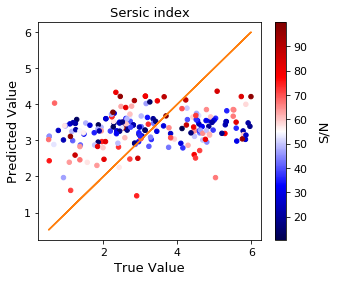

In [22]:
plot_prediction(cnnmodel1, label_ind)

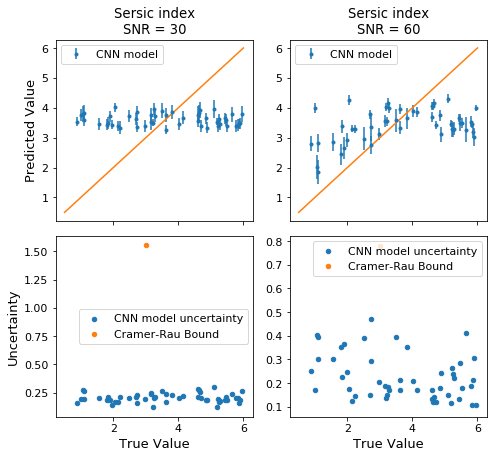

In [23]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [24]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [19]:
weights_filename = 'cnnmodel_index_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.876531. Weights saved.
==> Current val_loss lowest record is: 0.854893. Weights saved.
==> Current val_loss lowest record is: 0.834039. Weights saved.
==> Current val_loss lowest record is: 0.820071. Weights saved.
==> Current val_loss lowest record is: 0.808554. Weights saved.
==> Current val_loss lowest record is: 0.805676. Weights saved.
==> Current val_loss lowest record is: 0.802543. Weights saved.
==> Current val_loss lowest record is: 0.801512. Weights saved.
==> Current val_loss lowest record is: 0.800962. Weights saved.
==> Current val_loss lowest record is: 0.800794. Weights saved.
==> Current val_loss lowest record is: 0.800683. Weights saved.
==> Current val_loss lowest record is: 0.800590. Weights saved.
==> Current val_loss lowest record is: 0.800555. Weights saved.
==> Current val_loss lowest record is: 0.800550. Weights saved.
==> Current val_loss lowest record is: 0.800425. Weights saved.
==> Current val_loss lowest record is: 0

In [25]:
weights_filename = 'cnnmodel_index_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_index_v0.h5 from disk
The validation loss MAE is 0.800240.


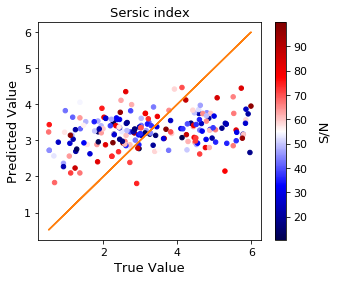

In [26]:
plot_prediction(cnnmodel1, label_ind)

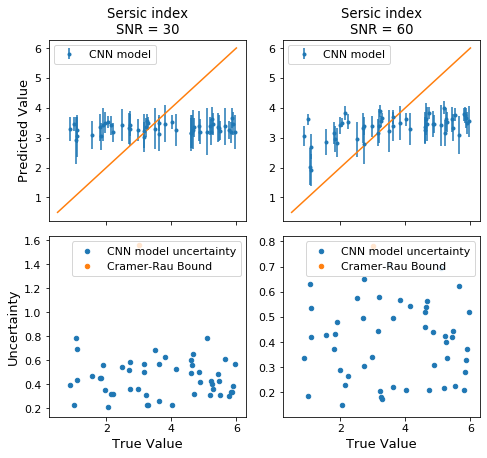

In [27]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 3: Deep CNN layers (channel number descending)

In [28]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [22]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.873166. Weights saved.
==> Current val_loss lowest record is: 0.866865. Weights saved.
==> Current val_loss lowest record is: 0.806643. Weights saved.
==> Current val_loss lowest record is: 0.795880. Weights saved.
==> Current val_loss lowest record is: 0.771939. Weights saved.
==> Current val_loss lowest record is: 0.747715. Weights saved.
==> Current val_loss lowest record is: 0.747371. Weights saved.
==> Current val_loss lowest record is: 0.744005. Weights saved.
==> Current val_loss lowest record is: 0.743563. Weights saved.
120 min has passed. Time is over!


In [26]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 240, verbose = 0)

==> Current val_loss lowest record is: 0.696807. Weights saved.
==> Current val_loss lowest record is: 0.683657. Weights saved.
==> Current val_loss lowest record is: 0.655153. Weights saved.
==> Current val_loss lowest record is: 0.650073. Weights saved.
==> Current val_loss lowest record is: 0.641599. Weights saved.
==> Current val_loss lowest record is: 0.637499. Weights saved.
==> Current val_loss lowest record is: 0.636515. Weights saved.
==> Current val_loss lowest record is: 0.636415. Weights saved.
240 min has passed. Time is over!


In [30]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_index_imprvd2.h5 from disk
The validation loss MAE is 0.636415.


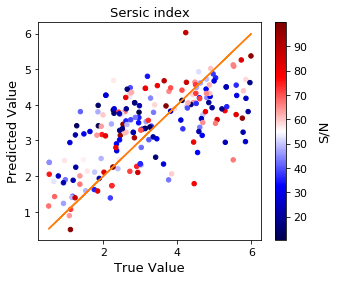

In [31]:
plot_prediction(cnnmodel1, label_ind)

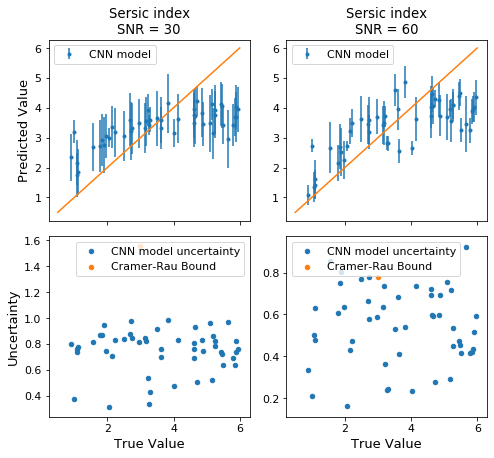

In [32]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

### Regression on the label2 Sersic radius

##### Architecture 1: Deep CNN layers:

In [33]:
label_ind = 2
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [26]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_radius_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.606371. Weights saved.
==> Current val_loss lowest record is: 0.602255. Weights saved.
==> Current val_loss lowest record is: 0.595163. Weights saved.
==> Current val_loss lowest record is: 0.590923. Weights saved.
==> Current val_loss lowest record is: 0.588613. Weights saved.
==> Current val_loss lowest record is: 0.586930. Weights saved.
==> Current val_loss lowest record is: 0.585905. Weights saved.
120 min has passed. Time is over!


In [34]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_radius_imprvd.h5')

Loaded cnnmodel_radius_imprvd.h5 from disk
The validation loss MAE is 0.585905.


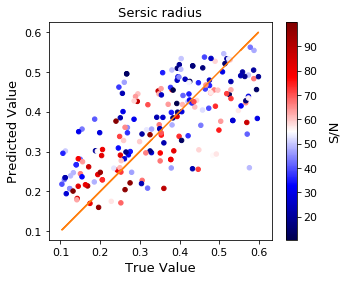

In [35]:
plot_prediction(cnnmodel1, label_ind)

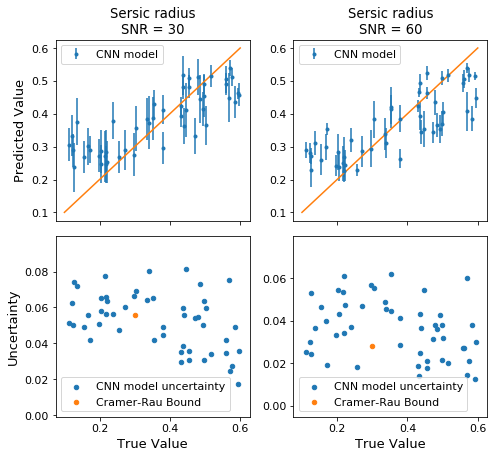

In [36]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [37]:
label_ind = 2
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [23]:
weights_filename = 'cnnmodel_radius_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.715939. Weights saved.
==> Current val_loss lowest record is: 0.682808. Weights saved.
==> Current val_loss lowest record is: 0.667680. Weights saved.
==> Current val_loss lowest record is: 0.644195. Weights saved.
==> Current val_loss lowest record is: 0.635084. Weights saved.
==> Current val_loss lowest record is: 0.628747. Weights saved.
==> Current val_loss lowest record is: 0.624590. Weights saved.
==> Current val_loss lowest record is: 0.624565. Weights saved.
120 min has passed. Time is over!


In [38]:
weights_filename = 'cnnmodel_radius_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_radius_v0.h5 from disk
The validation loss MAE is 0.624565.


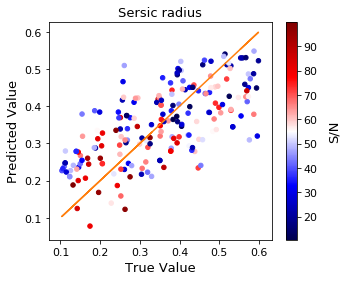

In [39]:
plot_prediction(cnnmodel1, label_ind)

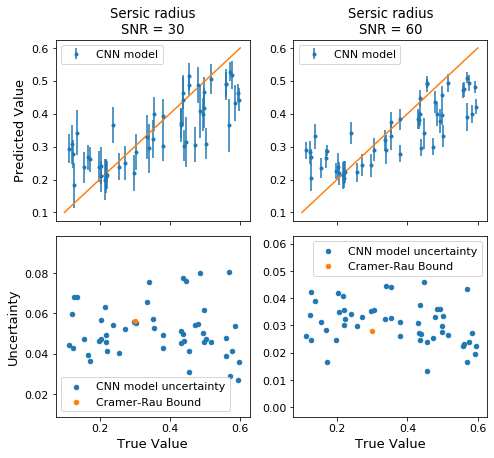

In [40]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

### Regression on the label3 g1

##### Architecture 1: Deep CNN layers:

In [41]:
label_ind = 3
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [30]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_g1_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.571557. Weights saved.
==> Current val_loss lowest record is: 0.524762. Weights saved.
==> Current val_loss lowest record is: 0.385629. Weights saved.
==> Current val_loss lowest record is: 0.364834. Weights saved.
==> Current val_loss lowest record is: 0.356564. Weights saved.
==> Current val_loss lowest record is: 0.356035. Weights saved.
==> Current val_loss lowest record is: 0.354792. Weights saved.
==> Current val_loss lowest record is: 0.353697. Weights saved.
120 min has passed. Time is over!


In [42]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_g1_imprvd.h5')

Loaded cnnmodel_g1_imprvd.h5 from disk
The validation loss MAE is 0.353697.


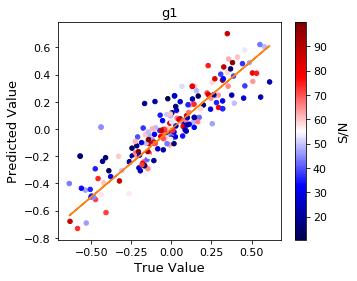

In [43]:
plot_prediction(cnnmodel1, label_ind)

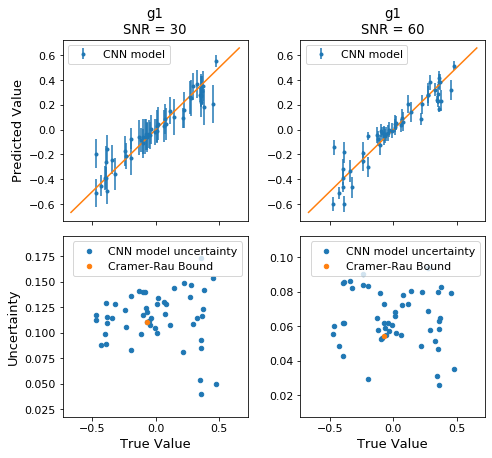

In [44]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [45]:
label_ind = 3
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [27]:
weights_filename = 'cnnmodel_g1_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.761530. Weights saved.
==> Current val_loss lowest record is: 0.616597. Weights saved.
==> Current val_loss lowest record is: 0.495579. Weights saved.
==> Current val_loss lowest record is: 0.384016. Weights saved.
==> Current val_loss lowest record is: 0.381391. Weights saved.
==> Current val_loss lowest record is: 0.376676. Weights saved.
==> Current val_loss lowest record is: 0.373073. Weights saved.
==> Current val_loss lowest record is: 0.371476. Weights saved.
==> Current val_loss lowest record is: 0.371211. Weights saved.
==> Current val_loss lowest record is: 0.371114. Weights saved.
==> Current val_loss lowest record is: 0.370799. Weights saved.
==> Current val_loss lowest record is: 0.370729. Weights saved.
==> Current val_loss lowest record is: 0.370654. Weights saved.
==> Current val_loss lowest record is: 0.370570. Weights saved.
120 min has passed. Time is over!


In [46]:
weights_filename = 'cnnmodel_g1_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g1_v0.h5 from disk
The validation loss MAE is 0.370570.


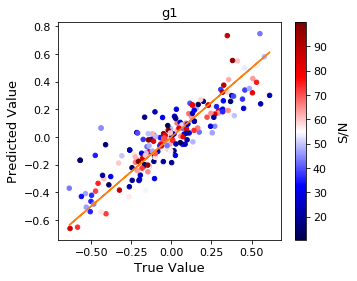

In [47]:
plot_prediction(cnnmodel1, label_ind)

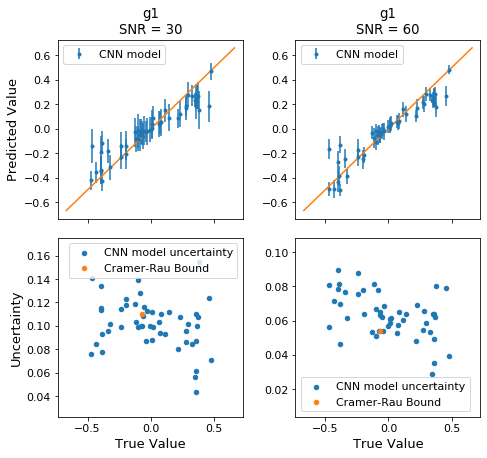

In [48]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

### Regression on the label4 g2

##### Architecture 1: Deep CNN layers:

In [49]:
label_ind = 4
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [34]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_g2_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.537747. Weights saved.
==> Current val_loss lowest record is: 0.407268. Weights saved.
==> Current val_loss lowest record is: 0.374907. Weights saved.
==> Current val_loss lowest record is: 0.366383. Weights saved.
==> Current val_loss lowest record is: 0.358592. Weights saved.
==> Current val_loss lowest record is: 0.353145. Weights saved.
==> Current val_loss lowest record is: 0.352322. Weights saved.
==> Current val_loss lowest record is: 0.350721. Weights saved.
==> Current val_loss lowest record is: 0.350544. Weights saved.
120 min has passed. Time is over!


In [50]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_g2_imprvd.h5')

Loaded cnnmodel_g2_imprvd.h5 from disk
The validation loss MAE is 0.350544.


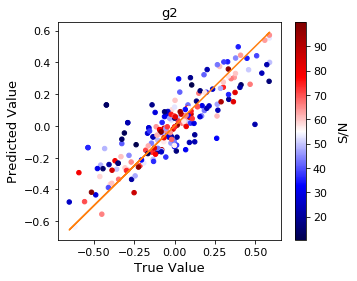

In [51]:
plot_prediction(cnnmodel1, label_ind)

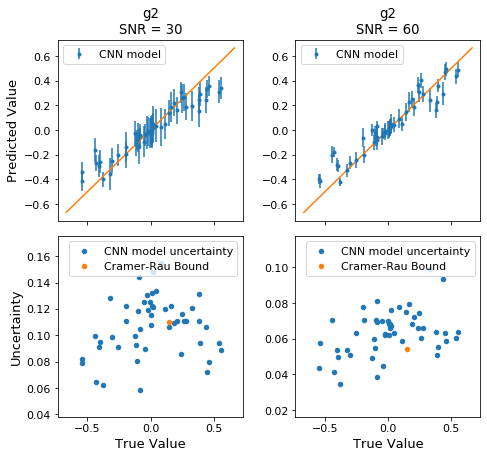

In [52]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [53]:
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [31]:
label_ind = 4
weights_filename = 'cnnmodel_g2_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.767866. Weights saved.
==> Current val_loss lowest record is: 0.533065. Weights saved.
==> Current val_loss lowest record is: 0.471258. Weights saved.
==> Current val_loss lowest record is: 0.441658. Weights saved.
==> Current val_loss lowest record is: 0.437752. Weights saved.
==> Current val_loss lowest record is: 0.435072. Weights saved.
==> Current val_loss lowest record is: 0.430595. Weights saved.
==> Current val_loss lowest record is: 0.425878. Weights saved.
==> Current val_loss lowest record is: 0.423592. Weights saved.
==> Current val_loss lowest record is: 0.423271. Weights saved.
==> Current val_loss lowest record is: 0.422234. Weights saved.
120 min has passed. Time is over!


In [54]:
weights_filename = 'cnnmodel_g2_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g2_v0.h5 from disk
The validation loss MAE is 0.422234.


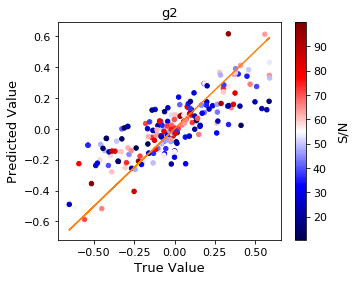

In [55]:
plot_prediction(cnnmodel1, label_ind)

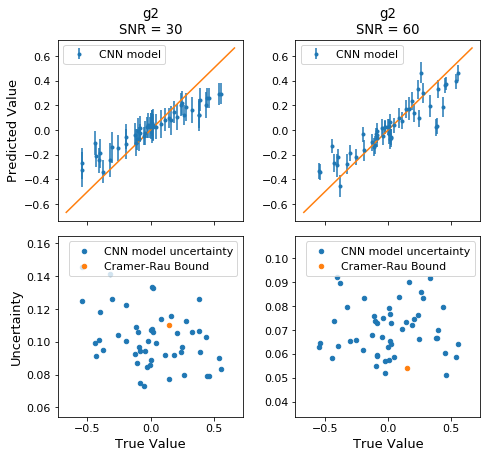

In [56]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100)